In [6]:
from transformers import AutoProcessor, AutoModelForImageTextToText
from peft import LoraConfig, get_peft_model, TaskType

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", use_fast=True)

In [7]:
processor.tokenizer.pad_token

'<|endoftext|>'

In [8]:
print(processor.tokenizer.encode("<|im_start|>assistant"))

[151644, 77091]


In [ ]:

model = AutoModelForImageTextToText.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    dtype="float16",
    device_map="auto",
)

model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2VLForConditionalGeneration(
  (model): Qwen2VLModel(
    (visual): Qwen2VisionTransformerPretrainedModel(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2VLVisionBlock(
          (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (attn): VisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): VisionMlp(
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (act): QuickGELUActivation()
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
        )
      )
      (merger): PatchMerger(
        (ln_q): LayerN

In [6]:
print(model.config)

Qwen2VLConfig {
  "architectures": [
    "Qwen2VLForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "float16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "image_token_id": 151655,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 32768,
  "max_window_layers": 28,
  "model_type": "qwen2_vl",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": {
    "mrope_section": [
      16,
      24,
      24
    ],
    "rope_type": "default",
    "type": "default"
  },
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "text_config": {
    "architectures": [
      "Qwen2VLForConditionalGeneration"
    ],
    "attention_dropout": 0.0,
    "bos_token_id": 151643,
    "dtype": "float16",
    "eos_token_id": 151645,
    "hidden_act": "silu",
    "hidden_size": 1536,
    "image_token_id": null,
    "initializer_ra

In [2]:
target_modules = [
    # text attention
    "q_proj", "k_proj", "v_proj", "o_proj",
    # text MLP
    "gate_proj", "up_proj", "down_proj",
    # vision attention
    "qkv", "proj",
    # vision MLP
    "fc1", "fc2",
    # merger: target only the Linear leaves (avoid the container)
    "visual.merger.mlp.0",
    "visual.merger.mlp.2",
]


peft_config = LoraConfig(
    target_modules=target_modules,
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
)

model = get_peft_model(model, peft_config)

model.print_trainable_parameters()

trainable params: 14,630,080 || all params: 2,223,615,680 || trainable%: 0.6579


In [1]:
from datasets import load_dataset, load_from_disk

raw_dataset = load_from_disk("datasets/latex80m_en_10k/")
raw_dataset

Dataset({
    features: ['image', 'latex_formula', 'category'],
    num_rows: 10
})

In [2]:
raw_dataset[3]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=191x22>,
 'latex_formula': '\\[x_{\\boldsymbol{\\alpha}}\\coloneqq x_{\\alpha_{1}}\\cdots x_{\\alpha_{\\ell}}\\]',
 'category': 'inline'}

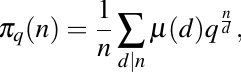

In [3]:
image, answer = raw_dataset[0]["image"], raw_dataset[0]["latex_formula"]

image

In [4]:
print(answer)

\[\pi_{q}(n)=\frac{1}{n}\sum_{d|n}\mu(d)q^{\frac{n}{d}},\]


In [37]:
msg = {
    "role": "user",
    "content": [
        {
            "type": "image",
            "image": image,
        },
        {
            "type": "text",
            "text": "Transcribe the given image to LaTeX.",
        },
    ],
}

inputs = processor.apply_chat_template(
    [msg],
    tokenize=True,
    return_dict=True,
    add_generation_prompt=True,
)

print(len(inputs["input_ids"][0]))
inputs


56


{'input_ids': [[151644, 8948, 198, 2610, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 151652, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151653, 3167, 3114, 279, 2661, 2168, 311, 97913, 13, 151645, 198, 151644, 77091, 198]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'pixel_values': tensor([[ 1.9303,  1.9303,  1.9303,  ...,  2.1459,  2.1459,  2.1459],
        [ 1.9303,  1.9303,  1.9303,  ...,  2.1459,  2.1459,  2.1459],
        [ 1.9303,  1.9303,  1.9303,  ..., -1.0252, -1.0394, -1.0821],
        ...,
        [ 1.9303,  1.9303,  1.9303,  ...,  2.1459,  2.1459,  2.1459],
        [ 1.9303,  1.9303,  1.9303,  ...,  2.1459,  2.1459,  2.1459],
        [ 1.9303,  

In [28]:
processor.decode(inputs["input_ids"][0])

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nTranscribe the given image to LaTeX.<|im_end|>\n<|im_start|>assistant\n'

In [25]:
msg = {
    "role": "user",
    "content": [
        {
            "type": "text",
            "text": "Transcribe the given image to LaTeX.",
        },
    ],
}

inputs = processor.apply_chat_template(
    [msg],
    tokenize=True,
    return_dict=True,
    add_generation_prompt=True,
)

inputs

{'input_ids': [[151644, 8948, 198, 2610, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 3167, 3114, 279, 2661, 2168, 311, 97913, 13, 151645, 198, 151644, 77091, 198]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [27]:
processor.decode(inputs["input_ids"][0])

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nTranscribe the given image to LaTeX.<|im_end|>\n<|im_start|>assistant\n'

In [32]:
processor.tokenizer("Transcribe the given image to LaTeX.")

{'input_ids': [3167, 3114, 279, 2661, 2168, 311, 97913, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [38]:
from PIL import Image

image = Image.open("datasets/2.jpg")

msg = {
    "role": "user",
    "content": [
        {
            "type": "image",
            "image": image,
        },
        {
            "type": "text",
            "text": "Transcribe the given image to LaTeX.",
        },
    ],
}

inputs = processor.apply_chat_template(
    [msg],
    tokenize=True,
    return_dict=True,
    add_generation_prompt=True,
)

print(len(inputs["input_ids"][0]))


16253


In [24]:
image, answer = raw_dataset[0]["image"], raw_dataset[0]["latex_formula"]

msg = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {
                "type": "text",
                "text": "Transcribe the given image to LaTeX.",
            },
        ],
    },
    {
        "role": "assistant",
        "content": [{"type": "text", "text": answer}],
    },
]

inputs = processor.apply_chat_template(
    [msg],
    tokenize=True,
    return_dict=True,
    add_generation_prompt=False,
)

print(len(inputs["input_ids"][0]))
inputs

92


{'input_ids': [[151644, 8948, 198, 2610, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 151652, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151653, 3167, 3114, 279, 2661, 2168, 311, 97913, 13, 151645, 198, 151644, 77091, 198, 59, 26056, 2493, 15159, 80, 25547, 77, 11730, 59, 37018, 90, 16, 15170, 77, 11035, 1242, 15159, 67, 91, 77, 11035, 15128, 1500, 8, 80, 61, 35702, 37018, 91362, 15170, 67, 38154, 59, 60, 151645, 198]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'pixel_values': tensor([[ 1.9303,  1.9303,  1.9303,  ...,  2.1459,  2.1459,  2.1459],
     

In [25]:
print(processor.apply_chat_template(
    [msg],
)[0])

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Transcribe the given image to LaTeX.<|im_end|>
<|im_start|>assistant
\[\pi_{q}(n)=\frac{1}{n}\sum_{d|n}\mu(d)q^{\frac{n}{d}},\]<|im_end|>



In [26]:
for key in inputs:
    print(key, end=", ")

input_ids, attention_mask, pixel_values, image_grid_thw, 

In [27]:
processor.tokenizer.special_tokens_map

{'eos_token': '<|im_end|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

In [28]:
print(processor.tokenizer.encode("<|im_start|>assistant"))

[151644, 77091]


In [29]:
input_ids = inputs["input_ids"][0]

input_ids

[151644,
 8948,
 198,
 2610,
 525,
 264,
 10950,
 17847,
 13,
 151645,
 198,
 151644,
 872,
 198,
 151652,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151653,
 3167,
 3114,
 279,
 2661,
 2168,
 311,
 97913,
 13,
 151645,
 198,
 151644,
 77091,
 198,
 59,
 26056,
 2493,
 15159,
 80,
 25547,
 77,
 11730,
 59,
 37018,
 90,
 16,
 15170,
 77,
 11035,
 1242,
 15159,
 67,
 91,
 77,
 11035,
 15128,
 1500,
 8,
 80,
 61,
 35702,
 37018,
 91362,
 15170,
 67,
 38154,
 59,
 60,
 151645,
 198]

In [35]:
image, answer = raw_dataset[0]["image"], raw_dataset[0]["latex_formula"]

prompt_msg = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {
                "type": "text",
                "text": "Transcribe the given image to LaTeX.",
            },
        ],
    },
]

full_msg = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {
                "type": "text",
                "text": "Transcribe the given image to LaTeX.",
            },
        ],
    },
    {
        "role": "assistant",
        "content": [{"type": "text", "text": answer}],
    },
]

prompt_input_ids = processor.apply_chat_template(
    prompt_msg,
    tokenize=True,
    return_dict=True,
    add_generation_prompt=True,
)["input_ids"]

inputs = processor.apply_chat_template(
    [full_msg],
    tokenize=True,
    return_dict=True,
    add_generation_prompt=False,
    return_tensors="pt",
)

labels = inputs["input_ids"][0][:]
labels[: len(prompt_input_ids)] = -100

unmasked_ids = inputs["input_ids"][0][len(prompt_input_ids) :]
processor.tokenizer.decode(unmasked_ids)

'system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|vision_end|>Transcribe the given image to LaTeX.<|im_end|>\n<|im_start|>assistant\n\\[\\pi_{q}(n)=\\frac{1}{n}\\sum_{d|n}\\mu(d)q^{\\frac{n}{d}},\\]<|im_end|>\n'

In [37]:
prompt_input_ids = processor.apply_chat_template(
    [prompt_msg],
    tokenize=True,
    # return_dict=True,
    add_generation_prompt=True,
)
print(prompt_input_ids)

[[151644, 8948, 198, 2610, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 151652, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151653, 3167, 3114, 279, 2661, 2168, 311, 97913, 13, 151645, 198, 151644, 77091, 198]]


In [54]:
raw_datasets = load_dataset("parquet", data_files="./datasets/latex80m_en_10k.parquet")

raw_datasets["train"] = load_dataset("parquet", data_files="./datasets/latex80m_en_10k.parquet", split="train[:90%]")
raw_datasets["validation"] = load_dataset("parquet", data_files="./datasets/latex80m_en_10k.parquet", split="train[90%:]")

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", use_fast=True)


def build_messages(image, latex_formula):
    user = {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Transcribe the given image to LaTeX."}
        ]
    }
    assistant = {
        "role": "assistant",
        "content": [{"type": "text", "text": latex_formula}]
    }
    return [user], [user, assistant]

def pre_process(example):
    image = example["image"]
    answer = example["latex_formula"]
    
    user_only_msgs, full_msgs = build_messages(image, answer)
    
    prompt_input_ids = processor.apply_chat_template(
        user_only_msgs,
        tokenize=True,
        return_dict=False,
        add_generation_prompt=True,
    )[0]
    prompt_len = len(prompt_input_ids)
    full_input_ids = processor.apply_chat_template(
        full_msgs,
        tokenize=True,
        return_dict=True,
        add_generation_prompt=False,
        return_tensors="pt",
    )
    labels = full_input_ids["input_ids"][0].clone()
    labels[:prompt_len] = -100
    return {
        **full_input_ids,
        "labels": labels,
    }

raw_datasets = raw_datasets.map(pre_process)

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [55]:
raw_datasets["train"][0].keys()

dict_keys(['image', 'latex_formula', 'category', 'input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])

In [66]:
inputs = raw_datasets["train"][3]

input_ids = inputs["input_ids"]
labels = inputs["labels"]
print(labels)

last_index = len(labels) - 1 - labels[::-1].index(-100)
print(last_index)

unmasked_ids = labels[last_index + 1:]
print(unmasked_ids)

print(processor.decode(unmasked_ids))

[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 78045, 87, 15159, 59, 14824, 18785, 35702, 7141, 3417, 59, 2074, 603, 27579, 856, 15159, 59, 7141, 15159, 16, 3417, 59, 4385, 2412, 856, 15159, 59, 7141, 15159, 59, 613, 3417, 59, 60, 151645, 198]
35
[78045, 87, 15159, 59, 14824, 18785, 35702, 7141, 3417, 59, 2074, 603, 27579, 856, 15159, 59, 7141, 15159, 16, 3417, 59, 4385, 2412, 856, 15159, 59, 7141, 15159, 59, 613, 3417, 59, 60, 151645, 198]
\[x_{\boldsymbol{\alpha}}\coloneqq x_{\alpha_{1}}\cdots x_{\alpha_{\ell}}\]<|im_end|>



In [ ]:
labels.index(-100, )

0

In [70]:
msg = {
    "role": "user",
    "content": [
        {
            "type": "image",
            "image": image,
        },
        {
            "type": "text",
            "text": "Transcribe the given image to LaTeX.",
        },
    ],
}

msg2 = {
    "role": "user",
    "content": [
        {"type": "text", "text": "Transcribe the aefeafaefeaf ae faef aef image to LaTeX."}
    ]
}

inputs = processor.apply_chat_template(
    [[msg], [msg2]],
    tokenize=True,
    return_dict=True,
    add_generation_prompt=True,
    padding=True,
)

print(inputs)

{'input_ids': [[151644, 8948, 198, 2610, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 151652, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151653, 3167, 3114, 279, 2661, 2168, 311, 97913, 13, 151645, 198, 151644, 77091, 198], [151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151644, 8948, 198, 2610, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 3167, 3114, 279, 264, 44953, 35834, 44953, 2577, 41856, 2218, 823, 264, 823, 2168, 311, 97913, 13, 151645, 198, 151644, 77091, 198]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0,

In [5]:
import torch

x = torch.tensor([
    [0, 1, 0, 2],
    [0, 0, 0, 0],
    [3, 0, 4, 0]
])

# Flip horizontally, find first non-zero from the right
rightmost = (x != 0).int().fliplr().argmax(dim=1)
print(rightmost)

# If a row has *no* non-zero, argmax returns 0 incorrectly — fix that:
mask = (x != 0).any(dim=1)
rightmost[mask] = x.shape[1] - 1 - rightmost[mask]
rightmost[~mask] = -1  # use -1 for "no non-zero"

print(rightmost)
# tensor([3, -1, 2])

tensor([0, 0, 1])
tensor([ 3, -1,  2])
